# Import Data - Multi-site example
In this example we see the power of scripting over Excel. Here we extract all sites for a given state (NC) and map them. Then we extract all sites within a specified 8-digit HUC (Upper Neuse: 03020201) and plot discharge histories for each. 

#### Import the modules used in this analysis

In [1]:
#Modules for retreiving data
import requests, io

#Modules for wrangling data
import pandas as pd
import numpy as np

#Modules for mapping
import folium

#Modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Enable inline plots in Jupyter
%matplotlib inline

#Use seaborn styles
sns.set(font_scale=2)

#### Format and execute the data request URL for the NWIS API

In [2]:
#Generate a list of all sites in NC using the NWIS API 
# see https://waterservices.usgs.gov/rest/DV-Service.html
url = 'http://waterservices.usgs.gov/nwis/site'
params = {'stateCd':'NC',        #NC Sites Only
          'siteStatus':'all', #Get all *active* sites
          'siteType':'ST',       #Stream sites only
          'parameterCd':'00060', #DISCHARGE(cfs), see https://help.waterdata.usgs.gov/codes-and-parameters/parameters
          'seriesCatalogOutput':'TRUE',
          'format':'rdb'         #RDB (csv)
         }

#Send the requests and translate the response
response_raw = requests.get(url,params)

#Decode to remove any odd characters (accents, etc.)
response_clean = response_raw.content.decode('utf-8')

#### Convert the retrieved data into a data frame

In [3]:
#Build a list of line numbers to skip from comments and data types
rowsToSkip= [] #Create an empty list to hold line numbers
lineNumber = 0 #Initialize a line number variable

#Iterate through lines, adding the line number to the list for comment lines
for lineNumber, lineString in enumerate(response_clean.split("\n")):
    if lineString.startswith('#'): 
        rowsToSkip.append(lineNumber)
    else:
        break
        
#Add another line 2 greater than the last
dataTypeLineNumber = rowsToSkip[-1] + 2
rowsToSkip.append(dataTypeLineNumber)

In [4]:
#Convert the data into a data frame
df = pd.read_csv(io.StringIO(response_clean),
                 skiprows=rowsToSkip,     #Skip metadta and data spec lines
                 delimiter='\t',          #Set to tab delimited
                 dtype={'site_no':'str',  #Set site_no to a string datatype
                        'stat_cd':'str',
                        'loc_web_ds':'str',
                        'huc_cd':'str'})  #Set huc_cd to a string datatype

In [5]:
#Convert date columns to dateobjects
df['begin_date'] = pd.to_datetime(df['begin_date'],format=('%Y-%m-%d'))
df['end_date'] = pd.to_datetime(df['end_date'],format=('%Y-%m-%d'))

In [6]:
#Add a column to list days of record (end minus begin dates)
df['period_days'] = (df['end_date'] - df['begin_date']).dt.days

In [7]:
#Create filters
startMask = df.begin_date <= '1950-01-01' #Sites that started collecting data < 1950
endMask =  df.end_date >= '2010-01-01'    #Sites that continued collection data > 2010
statMask = df.stat_cd == '00003'          #Select only "mean stream flow" records              
periodMask = df.period_days > (365 * 30)  #Sites with > 30 years of data
#Apply filters
df2 = df[startMask & endMask & statMask & periodMask]
df2.site_no.nunique()

67

#### Map the results, using Lat/Lng values

In [8]:
#Find center coordinates from medians of lat and long columns
meanLat = df2['dec_lat_va'].median()
meanLng = df2['dec_long_va'].median()

#Create the initial map
m = folium.Map(location=[meanLat,meanLng],
               zoom_start=7,
               tiles='stamenterrain')

#Loop through all features and add them to the map as markers
for row in df2.itertuples():
    #Get info for the record
    lat = row.dec_lat_va
    lng = row.dec_long_va
    name = row.station_nm
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=name,
                        color='red',
                        fill=True,
                        fill_opacity=0.6,
                        radius=5,
                        stroke=False).add_to(m)
#Show the map
m

In [9]:
#Save the file
m.save("NC_sites.html")

In [10]:
#Open in a browser
import webbrowser
webbrowser.open_new_tab("NC_sites.html")

True

## Show plots for a subset of points

In [11]:
#Subset records in Upper Neuse watershed (HUC8 = 03020201)
dfUpperNeuse = df2[df2['huc_cd'] == '03020201']

In [12]:
#Make a list of site numbers and names
siteNumbers = dfUpperNeuse['site_no'].unique().tolist()
siteNames = dfUpperNeuse['station_nm'].unique().tolist()

#Zip into a single list object
siteList = list(zip(siteNumbers, siteNames))

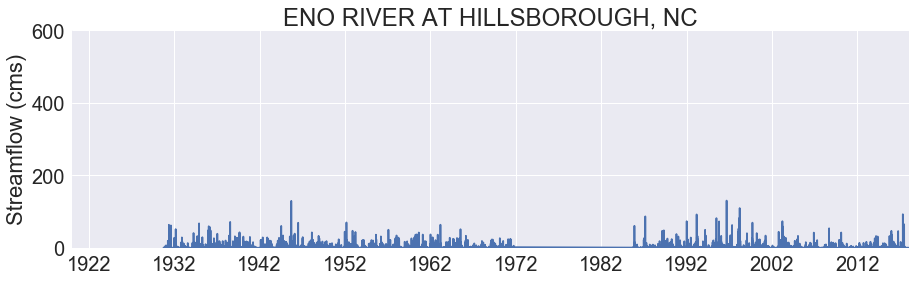

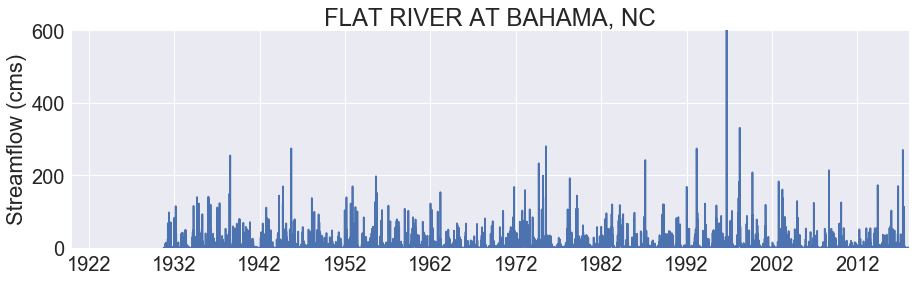

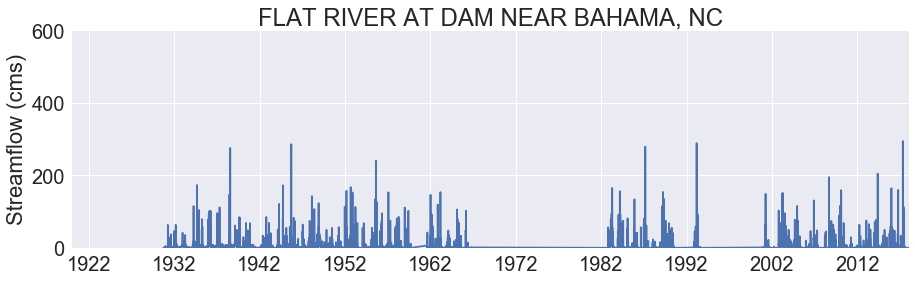

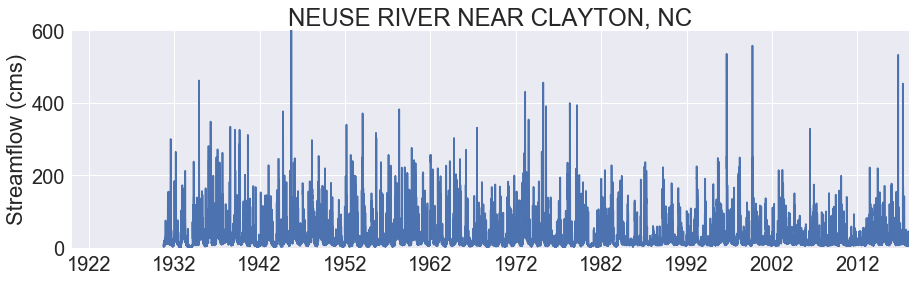

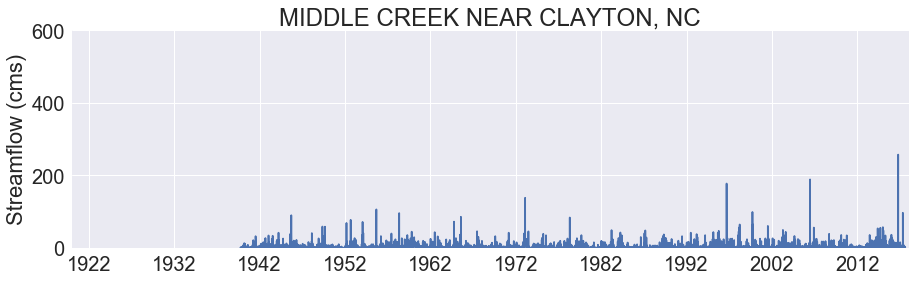

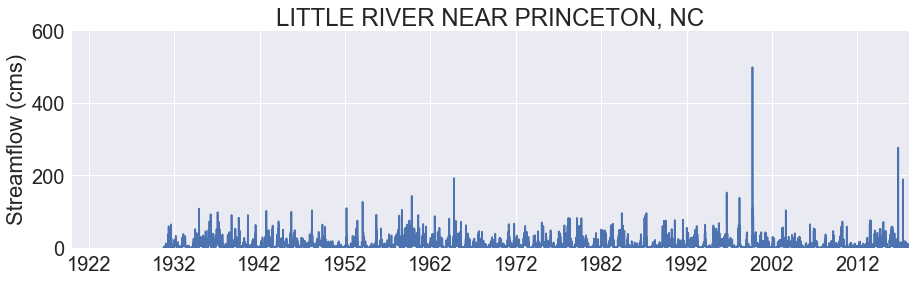

In [13]:
#Loop through each site
for siteNo, siteName in siteList:

    #Construct the service URL and parameters
    url =  'https://waterservices.usgs.gov/nwis/dv'
    params = {'sites':siteNo,
              'parameterCd':'00060',
              'statCd':'00003',
              'startDT':'1930-10-01',
              'endDT':'2017-12-31',
              'format':'rdb',
              'siteStatus':'all'
             }
    response_raw =  requests.get(url,params)
    response_clean =response_raw.content.decode('utf-8')
    
    #Convert the data into a data frame
    
    #Build a list of line numbers to skip from comments and data types
    rowsToSkip= [] #Create an empty list to hold line numbers
    lineNumber = 0 #Initialize a line number variable
    #Iterate through lines, adding the line number to the list for comment lines
    for lineNumber, lineString in enumerate(response_clean.split("\n")):
        if lineString.startswith('#'): 
            rowsToSkip.append(lineNumber)
        else:
            break
            
    #Add another line 2 greater than the last
    dataTypeLineNumber = rowsToSkip[-1] + 2
    rowsToSkip.append(dataTypeLineNumber)
    
    #Create a dataframe from the downloaded data
    dfSite = pd.read_csv(io.StringIO(response_clean),
                         skiprows=rowsToSkip,
                         delimiter='\t',
                         dtype={'site_no':'str'})

    #Convert datatype for datetime
    dfSite['datetime'] = pd.to_datetime(dfSite['datetime'])
    
    #Rename the columns
    dfSite.columns = ['agency_cd','site_no','datetime','meanflow_cfs','confidence']
    dfSite.index= dfSite.datetime
    
    #Fix any errors
    dfSite['flow'] = pd.to_numeric(dfSite['meanflow_cfs'],errors='coerce')
    dfSite['flow_cms'] = dfSite['flow'] * 0.028316847

    #PLOT
    fig = plt.figure(figsize=(15,4))
    ax=fig.add_subplot(111)
    ax.plot(dfSite['flow_cms'])
    ax.set_xlim(('1920-01-01','2017-12-31'))
    ax.set_ylim(0,600)
    ax.set_ylabel('Streamflow (cms)')
    ax.set_title(siteName)